# Modeling - Housing Price Prediction

## By: Nick Roller

## 1. Problem Statement:

Our client has asked us to produce a model to predict the expected price of a home given it's features, ammenities and attributes. As our dependant variable is continuous (dollar amount of home value) this will be a regression model. We will be exploring the following regression models, applying them to our dataset and determining the one that best suits our client's needs:
- Linear Regression
- Random Forest Regression
- Ridge Regression
- Lasso Regression

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from boruta import BorutaPy
from xgboost import XGBClassifier
from xgboost import plot_importance

In [2]:
pd.set_option('display.max_rows', 500)

We first load our preprocessed data. As we can see, we have already one-hot encoded the categorical variables and scaled all continuous ones.

In [3]:
df = pd.read_csv('Data Files/data_preprocessed.csv')
df.head()

,SalePrice,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,208500,65.0,8450,196.0,706,150,856,856,854,1710,...,0,0,0,1,0,0,0,0,1,0
1,181500,80.0,9600,0.0,978,284,1262,1262,0,1262,...,0,0,0,1,0,0,0,0,1,0
2,223500,68.0,11250,162.0,486,434,920,920,866,1786,...,0,0,0,1,0,0,0,0,1,0
3,250000,84.0,14260,350.0,655,490,1145,1145,1053,2198,...,0,0,0,1,0,0,0,0,1,0
4,307000,75.0,10084,186.0,1369,317,1686,1694,0,1694,...,0,0,0,1,0,0,0,0,1,0


In [4]:
#Engineering a new feature to take into account remodel age with the age of the house
#We're doing this because if there was no remodel, the feature value defaults to the house value
#This will allow for remodel age to be taken into account more accurately
df['Remod_Age_Avg']=(df['House_Age']+df['Remod_Age'])/2

We have already computed our optimal features during feature selection, so we will drop everything but our 10 selected features

In [5]:
selected_features = ['SalePrice','House_Age','GrLivArea','ExterQual_TA', 'TotalBsmtSF', 'GarageArea', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'LotArea','Remod_Age_Avg']

In [6]:
df = df[selected_features]

In [7]:
df.head()

,SalePrice,House_Age,GrLivArea,ExterQual_TA,TotalBsmtSF,GarageArea,1stFlrSF,2ndFlrSF,BsmtFinSF1,LotArea,Remod_Age_Avg
0,208500,18,1710,0,856,548,856,854,706,8450,9.0
1,181500,45,1262,1,1262,460,1262,0,978,9600,22.5
2,223500,20,1786,0,920,608,920,866,486,11250,19.5
3,250000,21,2198,0,1145,836,1145,1053,655,14260,10.5
4,307000,17,1694,0,1686,636,1694,0,1369,10084,16.5


## 2. Splitting training and test data

In [8]:
#We first prepare our train and test data sets
y=df['SalePrice'].values
X=df.drop('SalePrice', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

scaler = StandardScaler()
scaler.fit(X_train)
X_tr_scaled = scaler.transform(X_train)
X_te_scaled = scaler.transform(X_test)

In [9]:
X_train.shape, X_test.shape

((909, 10), (228, 10))

In [10]:
y_train.shape, y_test.shape

((909,), (228,))

## 3. Model Selection

### A. Evaluate performance of the mean

#### We will first evaluate how well simply taking the mean does in predicting home value, this will give us a baseline to compare our models against.

In [11]:
train_mean = y_train.mean()
train_mean

169730.35533553356

In [12]:
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[169730.35533553]])

In [13]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([169730.35533553, 169730.35533553, 169730.35533553, 169730.35533553,
       169730.35533553])

In [14]:
r2_score(y_train, y_tr_pred)

0.0

In [15]:
y_te_pred = train_mean * np.ones(len(y_test))
r2_score(y_test, y_te_pred)

-0.0002524619742851897

In [16]:
dumb_reg.predict(X_test)

array([169730.35533553, 169730.35533553, 169730.35533553, 169730.35533553,
       169730.35533553, 169730.35533553, 169730.35533553, 169730.35533553,
       169730.35533553, 169730.35533553, 169730.35533553, 169730.35533553,
       169730.35533553, 169730.35533553, 169730.35533553, 169730.35533553,
       169730.35533553, 169730.35533553, 169730.35533553, 169730.35533553,
       169730.35533553, 169730.35533553, 169730.35533553, 169730.35533553,
       169730.35533553, 169730.35533553, 169730.35533553, 169730.35533553,
       169730.35533553, 169730.35533553, 169730.35533553, 169730.35533553,
       169730.35533553, 169730.35533553, 169730.35533553, 169730.35533553,
       169730.35533553, 169730.35533553, 169730.35533553, 169730.35533553,
       169730.35533553, 169730.35533553, 169730.35533553, 169730.35533553,
       169730.35533553, 169730.35533553, 169730.35533553, 169730.35533553,
       169730.35533553, 169730.35533553, 169730.35533553, 169730.35533553,
       169730.35533553, 1

##### R^2

In [17]:
r_mean = dumb_reg.score(X_test, y_test)
print(r_mean)

-0.0002524619742851897


##### MAE

In [18]:
#MAE for dummy regression mean model
mae_mean = mean_absolute_error(y_test, y_te_pred)
mae_mean

50014.1068891977

##### MSE

In [19]:
#MSE for dummy regression mean model
mse_mean = mean_squared_error(y_test, y_te_pred)
mse_mean

4172406817.395602

### B. Linear Regression Model

In [20]:
#fit linear regression model and make prediction
reg = LinearRegression()
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)

In [21]:
#Print R^2
r2_score(y_test, y_pred)

0.7670640931071824

In [22]:
lr_mae = mean_absolute_error(y_test, y_pred)
lr_mae

20987.420951297605

In [23]:
lr_rmse = mean_squared_error(y_test, y_pred,squared=False)
lr_rmse

31171.4301761061

In [24]:
(mae_mean-lr_mae)/mae_mean

0.5803699744595344

In [25]:
(mse_mean-lr_rmse)/mse_mean

0.9999925291488725

Applying the basic lienar regression model has improved the prediction performance fairly significantly, MAE by 57% and MSE by 75% as we can see here.

#### Cross-Validation of linear model

In [26]:
#Importing CV score module and computing 5 fold scores

cv_scores = cross_val_score(reg, X, y, cv=5)

In [27]:
#Printing CV scores and their mean
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.80408697 0.83098894 0.80074983 0.82637733 0.79476308]
Average 5-Fold CV Score: 0.8113932295699945


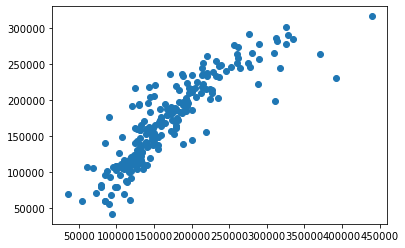

In [28]:
plt.scatter(y_test, y_pred)

### C. Random Forest Model

#### Make Pipeline

In [29]:
RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor()
)

#### Fit and assess using CV

In [30]:
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [31]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.83710054, 0.84072831, 0.86291418, 0.84771298, 0.89063589])

In [32]:
np.mean(rf_cv_scores)

0.8558183798376987

In [33]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.8558183798376987, 0.019526262581549568)

#### GridsearchCV

In [34]:
RF_pipe.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('randomforestregressor', RandomForestRegressor())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'randomforestregressor': RandomForestRegressor(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'randomforestregressor__bootstrap': True,
 'randomforestregressor__ccp_alpha': 0.0,
 'randomforestregressor__criterion': 'mse',
 'randomforestregressor__max_depth': None,
 'randomforestregressor__max_features': 'auto',
 'randomforestregressor__max_leaf_nodes': None,
 'randomforestregressor__max_samples': None,
 'randomforestregressor__min_impurity_decrease': 0.0,
 'randomforestregressor__min_impurity_split': None,
 'randomforestregressor__min_samples_leaf': 1,
 'randomforestregressor__min_samples_split': 2,
 'randomforestregressor__min_weight_fraction_leaf': 0.0,
 'randomforestregressor__n_estimators': 100,
 'randomforestregressor__n_jobs': None,
 'randomforest

In [35]:
# Number of trees in random forest
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
#n_est = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [10]
# Minimum number of samples required to split a node
min_samples_split = [5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2]
# Method of selecting samples for training each tree
bootstrap = [False]

grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'randomforestregressor__max_depth': max_depth,
        'randomforestregressor__max_features': max_features,
        'randomforestregressor__min_samples_split':min_samples_split,
        'randomforestregressor__min_samples_leaf':min_samples_leaf,
        'randomforestregressor__bootstrap': bootstrap,
        'standardscaler': [StandardScaler(), None]
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'randomforestregressor__max_depth': [10],
 'randomforestregressor__max_features': ['auto', 'sqrt', 'log2'],
 'randomforestregressor__min_samples_split': [5],
 'randomforestregressor__min_samples_leaf': [2],
 'randomforestregressor__bootstrap': [False],
 'standardscaler': [StandardScaler(), None]}

In [36]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [37]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'randomforestregressor__bootstrap': [False],
                         'randomforestregressor__max_depth': [10],
                         'randomforestregressor__max_features': ['auto', 'sqrt',
                                                                 'log2'],
                         'randomforestregressor__min_samples_leaf': [2],
                         'randomforestregressor__min_samples_split': [5],
                         'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143

In [38]:
rf_grid_cv.best_params_

{'randomforestregressor__bootstrap': False,
 'randomforestregressor__max_depth': 10,
 'randomforestregressor__max_features': 'sqrt',
 'randomforestregressor__min_samples_leaf': 2,
 'randomforestregressor__min_samples_split': 5,
 'randomforestregressor__n_estimators': 112,
 'standardscaler': StandardScaler()}

In [39]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.86259388, 0.84426448, 0.86226146, 0.8519411 , 0.88168233])

In [40]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.8605486502791425, 0.012593752932458988)

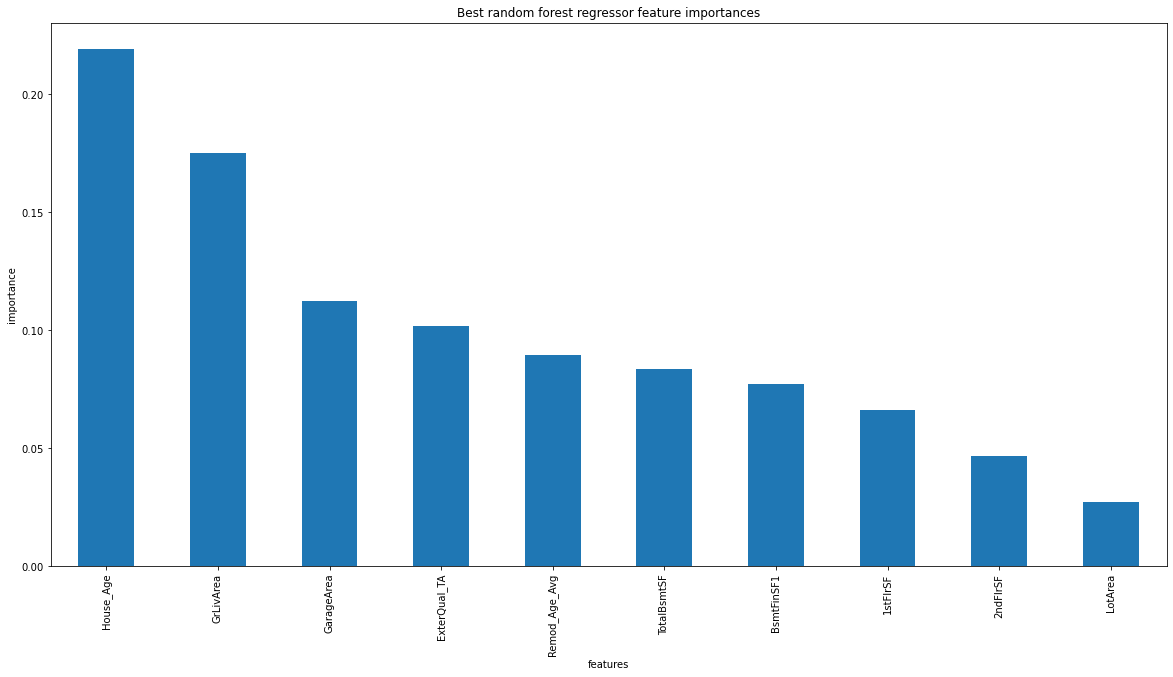

In [41]:
plt.subplots(figsize=(20, 10))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [42]:
rf_feat_imps

House_Age        0.219354
GrLivArea        0.175228
GarageArea       0.112457
ExterQual_TA     0.102067
Remod_Age_Avg    0.089628
TotalBsmtSF      0.083462
BsmtFinSF1       0.077100
1stFlrSF         0.066472
2ndFlrSF         0.046819
LotArea          0.027411
dtype: float64

### 3. Lasso Regression Model

In [43]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.4, normalize=True)
lasso.fit(X_train,y_train)

Lasso(alpha=0.4, normalize=True)

In [44]:
df_vars=df.drop('SalePrice',axis=1)
colnames = df_vars.columns

In [45]:
lasso_coef = lasso.coef_
pd.Series(lasso_coef, index=colnames).sort_values(ascending=False)

Remod_Age_Avg      387.428849
GrLivArea           60.181647
GarageArea          45.466594
BsmtFinSF1          27.691180
TotalBsmtSF         27.072048
LotArea              1.326299
2ndFlrSF             0.657537
1stFlrSF             0.000000
House_Age         -740.318315
ExterQual_TA    -25458.578614
dtype: float64

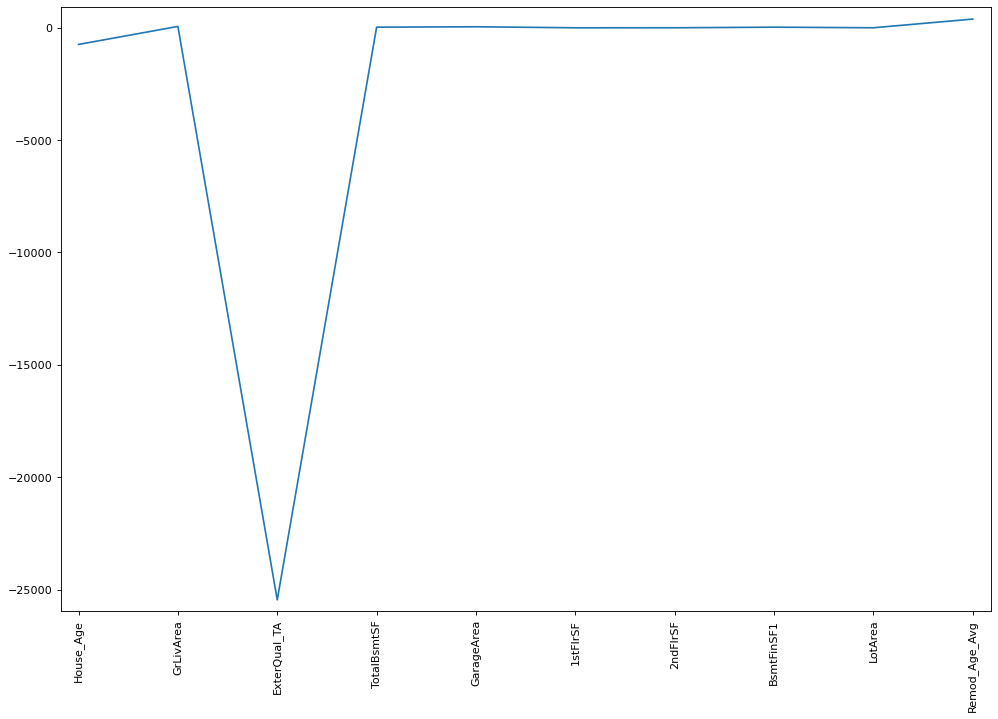

In [46]:
# Plot the coefficients
from matplotlib.pyplot import figure
figure(figsize=(15, 10), dpi=80)
plt.plot(range(len(colnames)), lasso_coef)
plt.xticks(range(len(colnames)), colnames.values, rotation=90) 
plt.margins(0.02)
plt.show()

### 4. Ridge Regression Model

In [47]:
from sklearn.linear_model import Ridge

alpha_space = np.logspace(-4, 0, 50)
ridge_scores = []
ridge_scores_std = []

ridge = Ridge(normalize=True)

In [48]:
for alpha in alpha_space:
    ridge.alpha = alpha
    ridge_cv_scores = cross_val_score(ridge, X, y, cv=10)
    ridge_scores.append(np.mean(ridge_cv_scores))
    ridge_scores_std.append(np.std(ridge_cv_scores))

In [49]:
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()


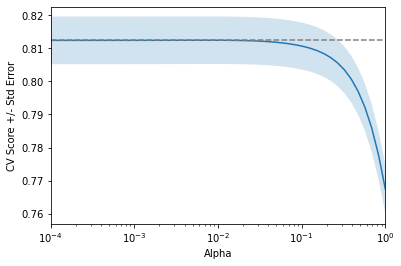

In [50]:
display_plot(ridge_scores, ridge_scores_std)

## 4. Model Performance

Since we are comparing several different random models, we will be using the root mean squared error as our performance metric since it keeps the units constant for the dependent variable.

### Linear Regression Model

In [63]:
lr_neg_mae = cross_validate(reg, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)

In [64]:
lr_rmse_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_rmse_std = np.std(-1 * lr_neg_mae['test_score'])
lr_rmse_mean, lr_rmse_std

(26574.189612910464, 3822.0103200512167)

In [65]:
mean_squared_error(y_test, reg.predict(X_test), squared=False)

31171.4301761061

### Random Forest Model

In [66]:
rf_neg_rmse = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)

In [67]:
rf_rmse_mean = np.mean(-1 * rf_neg_rmse['test_score'])
rf_rmse_std = np.std(-1 * rf_neg_rmse['test_score'])
rf_rmse_mean, rf_rmse_std

(23666.21402974677, 3509.9095465392493)

In [68]:
mean_squared_error(y_test, rf_grid_cv.best_estimator_.predict(X_test), squared=False)

27345.542414821277

### Lasso Regression Model

In [69]:
lasso_neg_rmse = cross_validate(lasso, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)

In [70]:
lasso_rmse_mean = np.mean(-1 * lasso_neg_rmse['test_score'])
lasso_rmse_std = np.std(-1 * lasso_neg_rmse['test_score'])
lasso_rmse_mean, lasso_rmse_std

(26549.75781004023, 3850.807748024854)

In [71]:
mean_squared_error(y_test, lasso.predict(X_test),squared=False)

31161.294204114787

### Ridge Regression Model

In [72]:
ridge_neg_rmse = cross_validate(ridge, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
ridge.fit(X_train, y_train)

Ridge(normalize=True)

In [73]:
ridge_rmse_mean = np.mean(-1 * ridge_neg_rmse['test_score'])
ridge_rmse_std = np.std(-1 * ridge_neg_rmse['test_score'])
ridge_rmse_mean, ridge_rmse_std

(29872.184042059194, 5846.207879966645)

In [74]:
mean_squared_error(y_test, ridge.predict(X_test),squared=False)

33365.66155011008

## Conclusion

After having narrowed down our features to the top 10 in terms of feature importance, we then ran four different regression models to determine which was best for predicting a home's sale price. We ran a basic linear regression model in addition to random forest, lasso and ridge regression models. After using these models to predict on our test set with 5 fold cross validation, we have determined the Forest Regression model to be the preferred and best performing model. Based on our chosen our model, the four greatest predictors for a home's value is the general living area square footage, the exterior quality of the home, the size of the garage and the size of the basement. Our model have a mean absolute error of roughly 17,285 dollars, so it can predict a home's value +/- 8,643 dollars.